Аэродинамика
---
Вычисления для курсача за минуту (опять все списали)

Исходные данные, для выполнения работы.
В коментах написано что за что отвечает.
Менять переменные нужно только в блоке ниже, все остальное уже зависит от них

In [2]:
# Отклонение от стандартной атмосферы
H = 2000
detT = 15

In [3]:
#Махи дозвуковые
M_min = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#Махи сверхзвуковые
M_max = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]

In [4]:
#Фюзеляж
f_params = [
    # Название, длинна, диаметр
    # Фюзеляж обязательно первый.
    ["Фюзеляж", 16.1, 1.74],
    ["Цилиндрическая часть", 3.7, 1.74],
    ["Носовая часть", 4.8, 0.87],
    ["Кормовая часть", 7.6, 1.16],
]

In [5]:
#Несущие поверхности (w - wing)
# Крыло -> Название, элементы, повторения
# Элеметн крыла -> b_0, b_k, l
w_params = [
    "Крыло", 
    [
        [9.8, 3.2, 7 - 5.54], 
        [3.2, 1.17, 5.54]
    ],
    2
]
ho_params = ["ГО", [[3.19, 1.02, 4.65]], 2]
vo_params = ["ВО", [[5.55, 1.17, 2.14]], 2]
#Параметры для консольных частей (без учета части, которая в фюзеляже)
w_params_k = [
    "Крыло", 
    [
        [5.55, 3.2, 7 - 5.54 - (14.0-12.2)/2], 
        [3.2, 1.17, 5.54]
    ],
    2
]
ho_params_k = ["ГО", [[3.19, 1.02, 3.49]], 2]
vo_params_k = ["ВО", [[5.55, 1.17, 2.14]], 2]
#стреловидность
a_wing = 71.0
#толщина профиля
c_ = 0.05 #c_max / b * 100$

Константы для вычислений

In [6]:
g0 = 9.80665
R = 287.05287
PR = 10.1972

Импорты для работы и функции для асиста

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

Таблицы с коэфициентами
(Функции, выдающие нам нужные для рассчетов значения, в зависимости от исходных данных)

In [8]:
def hg0(hg):
    if (0 <= hg and hg < 11000.0): return 0.0
    if (11000.0 <= hg and hg < 20000.0): return 11000.0
    if (20000.0 <= hg): return 20000.0

def t0(hg):
    if (0 <= hg and hg < 11000.0): return 288.15
    if (11000.0 <= hg and hg < 20000.0): return 216.65
    if (20000.0 <= hg): return 216.65

def p0(hg):
    if (0 <= hg and hg < 11000.0): return 1013.25
    if (11000.0 <= hg and hg < 20000.0): return 226.32
    if (20000.0 <= hg): return 54.7487


def b0(hg):
    if (0 <= hg and hg < 11000.0): return -0.0065
    if (11000.0 <= hg and hg < 20000.0): return 0.0
    if (20000.0 <= hg): return 0.001

pd.DataFrame([
    ["Hg 0", hg0(0), hg0(15000), hg0(30000)],
    ["T 0", t0(0), t0(15000), t0(30000)],
    ["P 0", p0(0), p0(15000), p0(30000)],
    ["B 0", b0(0), b0(15000), b0(30000)],], 
    columns=["Параметр", "Hg < 11000", "11000 <= Hg < 20000", "20000 <= Hg "],
)

,Параметр,Hg < 11000,11000 <= Hg < 20000,20000 <= Hg
0,Hg 0,0.0000,11000.00,20000.0000
1,T 0,288.1500,216.65,216.6500
2,P 0,1013.2500,226.32,54.7487
3,B 0,-0.0065,0.00,0.0010


Вычисление параметров стандартной атмосферы
---
Под этим блоком выводятся все необходимые данные по атмосфере

In [9]:
from math import *

hg = (6356766.0 * H) / (6356766.0 + H)
detH = hg - hg0(hg)
T = t0(hg) + b0(hg)*detH + detT
P = p0(hg) * exp((-g0 * detH) / (R * t0(hg))) if (11000.0 <= hg and hg < 20000.0 ) else p0(hg)* pow(1 + b0(hg)/t0(hg)*detH, -g0 /(b0(hg)* R))
ro = (P * PR) / (R * T)
a = 20.046796 * sqrt(T)

pd.DataFrame([[H, detT, hg, detH, T, P, ro, a]], columns=["H", "detT", "hg", "detH", "T", "P", "ro", "a"])

,H,detT,hg,detH,T,P,ro,a
0,2000,15,1999.370947,1999.370947,290.154089,795.014111,0.097334,341.475318


Определение геометрических параметров фюзеляжа
---
Тут просто нормально отображаются данные введенные в начале + считаются некоторые параметры.

In [10]:
#sample_str[ 0 : N ]
S_f = pow(f_params[0][2]/2, 2) * pi
tableData = []
for part in f_params:
    tableData.append([part[0] + " (длина)", "L_" +str(part[0][0:3]), part[1]])
for part in f_params:
    tableData.append([part[0] + " (диаметр)", "D_" +str(part[0][0:3]), part[2]])
for part in f_params:
    tableData.append([part[0] + " (удлинение)", "Lambda_" +str(part[0][0:3]), (part[1]/f_params[0][2])])
for part in f_params:
    n = part[2]/f_params[0][2]
    if n != 1: tableData.append([part[0] + " (Сужение)", "n" +str([part[0][0:3]]), n])
pd.DataFrame(tableData, columns=["Название", "Обозначение", "Значение"])

,Название,Обозначение,Значение
0,Фюзеляж (длина),L_Фюз,16.100000
1,Цилиндрическая часть (длина),L_Цил,3.700000
2,Носовая часть (длина),L_Нос,4.800000
3,Кормовая часть (длина),L_Кор,7.600000
4,Фюзеляж (диаметр),D_Фюз,1.740000
5,Цилиндрическая часть (диаметр),D_Цил,1.740000
6,Носовая часть (диаметр),D_Нос,0.870000
7,Кормовая часть (диаметр),D_Кор,1.160000
8,Фюзеляж (удлинение),Lambda_Фюз,9.252874
9,Цилиндрическая часть (удлинение),Lambda_Цил,2.126437


Определение геометрических параметров несущей поверхности
---
Рассчитаем следующие относительные геометрические параметры несущей поверхности:

In [11]:
def wing_l(wing, c = -1):
    l = 0
    for part in wing[1]:
        l += part[2]
    return l * (wing[2] if c < 0 else c)

def wing_s(wing, c = -1):
    s = 0
    for part in wing[1]:
        s += (part[0] + part[1]) / 2 * part[2]
    return s * (wing[2] if c < 0 else c)

def lambd(wing):
    return  pow(wing_l(wing), 2)/wing_s(wing)

def n(wing):
    return wing[1][0][0]/wing[1][-1][1]

In [12]:
tableData = [
    ["Размах крыла", "l", wing_l(w_params)],
    ["Площадь крыла", "S", wing_s(w_params)],
    ["Размах консольной части крыла", "l_ккр", wing_l(w_params_k)],
    ["Площадь консольной части крыла", "S_ккр", wing_s(w_params_k)],
    ["Высота вертикального оперения", "l_во", wing_l(vo_params, 1)],
    ["Площадь вертикального оперения", "S_во", wing_s(vo_params, 1)],
    ["Концевая хорда крыла", "b_k", w_params[1][-1][1]],
    ["Корневая хорда крыла", "b_б", w_params_k[1][0][0]],
    ["Центральная хорда крыла", "b_0", w_params[1][0][0]],
    ["Удлинение несущей поверхности", "lambda", lambd(w_params)],
    ["Удлинение консольной части несущей поверхности", "lambda_k", lambd(w_params_k)],
    ["Удлинение ВО", "lambda_во", lambd(vo_params_k)],
    ["Сужение несущей поверхности с подф. частью", "n", n(w_params)],
    ["Сужение консольной части несущей поверхности", "n_k", n(w_params_k)],
    ["Размах горизонтального оперения", "l_го", wing_l(ho_params, 1)],
    ["Площадь горизонтального оперения", "S_го", wing_s(ho_params, 1)],
    ["Размах консольной части ГО", "l_го", wing_l(ho_params_k, 1)],
    ["Площадь консольной части ГО", "S_го", wing_s(ho_params_k, 1)],
    ["Концевая хорда ГО", "b_kго", ho_params_k[1][-1][1]],
    ["Корневая хорда ГО", "b_бго", ho_params_k[1][0][0]],
    ["Удлинение ГО", "lambda_го", lambd(ho_params)],
    ["Удлинение консольной части ГО", "lambda_kго", lambd(ho_params_k)],
    ["Сужение ГО", "n_го", n(ho_params)],
    ["Сужение консольной части ГО", "n_kго", n(ho_params_k)],
]
pd.DataFrame(tableData, columns=["Название", "Обозначение", "Значение"])

,Название,Обозначение,Значение
0,Размах крыла,l,14.000000
1,Площадь крыла,S,43.189800
2,Размах консольной части крыла,l_ккр,12.200000
3,Площадь консольной части крыла,S_ккр,29.109800
4,Высота вертикального оперения,l_во,2.140000
5,Площадь вертикального оперения,S_во,7.190400
6,Концевая хорда крыла,b_k,1.170000
7,Корневая хорда крыла,b_б,5.550000
8,Центральная хорда крыла,b_0,9.800000
9,Удлинение несущей поверхности,lambda,4.538109


Определение САХ крыла
---
Сах определяется путем разбиения сложного крыла на простые состовные части, путем опрелеления САХ для каждой секции.
Сначала определяем САХ полного крыла с подфюзеляжной частью.

In [13]:
def SAH_simple(b_0, b_k, l):
    n = b_0 / b_k
    S = (b_0 + b_k) / 2 * l
    lamb = pow(l, 2) / S 
    return (4 / 3) * ((n*n + n +1) / pow(n+1, 2)) * sqrt(S / lamb), S

def SAH_simple_params(b_0, b_k, l):
    n = b_0 / b_k
    S = (b_0 + b_k) / 2 * l
    lamb = pow(l, 2) / S
    sah = (4 / 3) * ((n*n + n +1) / pow(n+1, 2)) * sqrt(S / lamb) 
    return S, n, lamb, sah

def SAH(wing):
    topSum = 0
    bototmSum = 0
    l = 0
    for part in wing[1]:
        l += part[2] * 2
        b , S = SAH_simple(part[0], part[1], part[2])
        topSum += b*S
        bototmSum += S
    return topSum/bototmSum

Параметры для вычисления САХ

In [14]:
tableData = []
i = 0
l = 0
for part in w_params[1]:
    i += 1
    l += part[2] * 2
    S, n, lamb, sah = SAH_simple_params(part[0], part[1], part[2])
    tableData.append(["n_" + str(i), n])
    tableData.append(["lambda_" + str(i), lamb])
    tableData.append(["S_" + str(i), S])
    tableData.append(["l_" + str(i), l])
    tableData.append(["САХ простого крыла " + str(i), sah])
pd.DataFrame(tableData, columns=["Обозначение", "Значение"])

,Обозначение,Значение
0,n_1,3.062500
1,lambda_1,0.224615
2,S_1,9.490000
3,l_1,2.920000
4,САХ простого крыла 1,7.058462
5,n_2,2.735043
6,lambda_2,2.535469
7,S_2,12.104900
8,l_2,14.000000
9,САХ простого крыла 2,2.342166


Вычисление САХ

In [15]:
tableData = [["САХ сложного крылв", "b", SAH(w_params)]]
pd.DataFrame(tableData, columns=[ "","Обозначение", "Значение"])

,,Обозначение,Значение
0,САХ сложного крылв,b,4.414769


Параметры для вычисления САХ консольной части крыла

In [16]:
tableData = []
i = 0
l = 0
for part in w_params_k[1]:
    i += 1
    l += part[2] * 2
    S, n, lamb, sah = SAH_simple_params(part[0], part[1], l)
    tableData.append(["n_" + str(i), n])
    tableData.append(["lambda_" + str(i), lamb])
    tableData.append(["S_" + str(i), S])
    tableData.append(["l_" + str(i), l])
    tableData.append(["САХ простого крыла " + str(i), sah])
pd.DataFrame(tableData, columns=["Обозначение", "Значение"])

,Обозначение,Значение
0,n_1,1.734375
1,lambda_1,0.256000
2,S_1,4.900000
3,l_1,1.120000
4,САХ простого крыла 1,4.480190
5,n_2,2.735043
6,lambda_2,5.583524
7,S_2,26.657000
8,l_2,12.200000
9,САХ простого крыла 2,2.342166


Вычисление САХ консольной части крыла

In [17]:
tableData = [["САХ сложного крылв", "b", SAH(w_params_k)]]
pd.DataFrame(tableData, columns=[ "","Обозначение", "Значение"])

,,Обозначение,Значение
0,САХ сложного крылв,b,2.702056


Определение критического числа Маха
---
Критическое число Маха самолета можно считать равным M_кр крыла для нормальной аэродинамической схемы.
Так как аэродинамические коэффициенты фюзеляжа в трансзвуковом диапазоне чисел Маха изменяются более плавно, чем соответствующие коэффициенты крыла или ПГО, то вполне допустимо пренебречь значением M_кр фюзеляжа, меньшим по величине числа M_кр крыла или ПГО.

In [18]:
Cya = 0
M_krpr = 1 - 0.7 * sqrt(c_) - 3.2 * c_ * pow(Cya, 1.5)

tableData = [["Мах критический", "Mкр", M_krpr]]
pd.DataFrame(tableData, columns=[ "","Обозначение", "Значение"])

,,Обозначение,Значение
0,Мах критический,Mкр,0.843475


Теперь по графику нужно определить параметры относительно полученных выше данных.

Определение коэффициента подъемной силы самолета
---
Производная коэффициента подъемной силы самолета определяется по соотношению:
	C_(ya )^α=C_yaф^α S ̅_ф+C_yaккр^α K_ααкр K_кр S ̅_кр η ̃_кр+C_yaкго^α K_ααго K_го S ̅_го η ̃_го+∑_(j=1)^n▒〖C_yaj^α K_j S ̅_j 〗.
    

In [19]:
S = wing_s(w_params)
S_kkr = wing_s(w_params_k)
S_kgo = wing_s(ho_params)

S_f1 = S_f / S
S_kr1 = S_kkr / S
S_go1 = S_kgo / S

tableData = [
    ["S_f1", S_f1],
    ["S_kr1", S_kr1],
    ["S_go1", S_go1],
]
pd.DataFrame(tableData, columns=[ "Обозначение", "Значение"])

,Обозначение,Значение
0,S_f1,0.055056
1,S_kr1,0.673997
2,S_go1,0.453267


Тест графиков
---
Можно этот блок не удалять, он потом пригодится для графиков (c него можно списать их инициализацию)

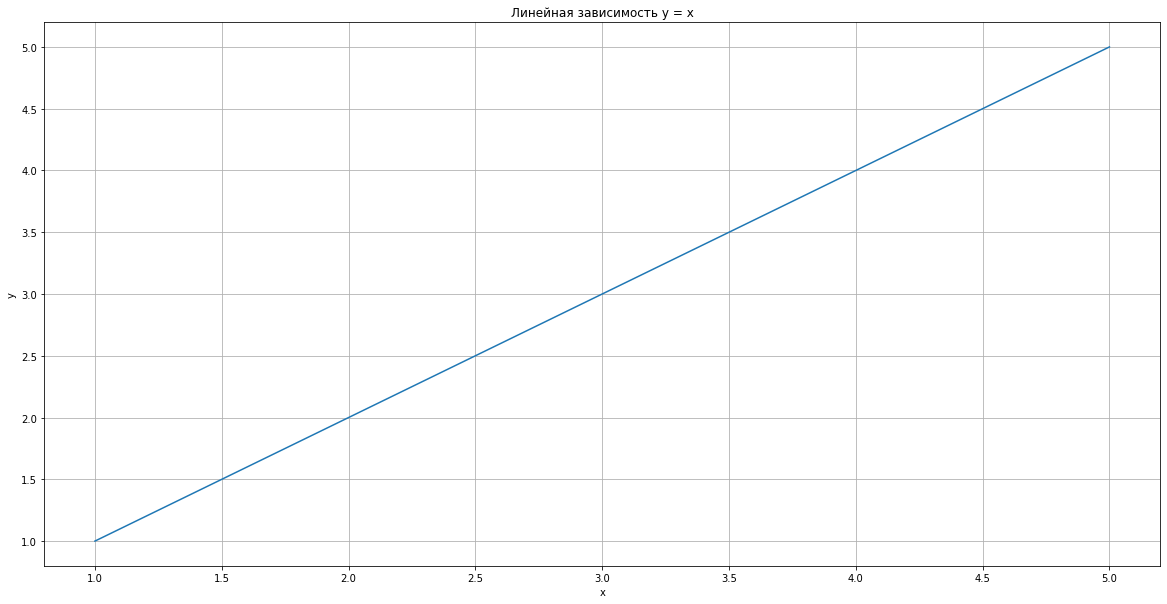

In [20]:
plt.plot([1, 2, 3, 4, 5], [1, 2, 3, 4, 5])
plt.title("Линейная зависимость y = x") # заголовок
plt.xlabel("x") # ось абсцисс
plt.ylabel("y") # ось ординат
plt.grid()      # включение отображение сетки